In [1]:
from collections import deque
from math import fabs, inf
from typing import Dict, List, Optional, Tuple

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

In [2]:
Vertex = Tuple[int, int]

OPEN = 1
WALL = -1


def create_grid_graph(
    size: int, add_walls: bool = False, with_costs: bool = False
) -> np.ndarray:
    """Create a grid-style graph (optionally with wall and edge costs).

    Args:
        size (int): size of the square graph edge
        add_walls (bool, optional): optionally add set walls. Defaults to False.
        with_costs (bool, optional): optionally add edge costs. Defaults to False.

    Returns:
        np.ndarray: a grid graph
    """

    if with_costs:
        grid = np.random.randint(low=OPEN + 1, high=10, size=(size, size), dtype=int)
    else:
        grid = np.ones((size, size), dtype=int) * OPEN

    if add_walls:
        grid[2, 2:-2] = WALL  # Lower horizontal wall
        grid[-3, 2:-2] = WALL  # Upper horizontal wall
        grid[3:-3, -3] = WALL  # Vertical wall
        grid[5:-5, 8] = WALL  # Isolated vertical wall

    return grid


def show_grid_graph(
    graph: np.ndarray,
    title: str,
    start: Optional[Vertex] = None,
    end: Optional[Vertex] = None,
    path: Optional[List[Vertex]] = None,
    visited: Optional[List[Vertex]] = None,
    with_costs: bool = False,
    ax: plt.Axes = None,
    show_legend: bool = True,
):
    """Plot a grid graph.

    Args:
        graph (np.ndarray): a grid graph
        title (str): title to display above the graph
        start (Optional[Vertex], optional): start vertex of path. Defaults to None.
        end (Optional[Vertex], optional): end vertex of path. Defaults to None.
        path (Optional[List[Vertex]], optional): path from start to end. Defaults to None.
        visited (Optional[List[Vertex]], optional): list of vertices visited during search. Defaults to None.
        with_costs (bool, optional): graph includes edge costs. Defaults to False.
        ax (plt.Axes, optional): axis on which to plot. Defaults to None.
    """

    if ax == None:
        _, ax = plt.subplots(1, 1, figsize=(8, 8))

    # A list of proxy patches for a custom legend
    ppatches = []

    YELLOW = (255, 255, 0)
    LIGHT_GRAY = (200, 200, 200)
    BLUE = (0, 0, 255)
    RED = (255, 0, 0)
    BLACK = (0, 0, 0)
    WHITE = (255, 255, 255)

    # Expand graph to three channels to plot as an image
    graph_img = np.repeat(graph[:, :, np.newaxis], 3, axis=2)
    graph_img[graph == OPEN] = WHITE
    ppatches.append(mpatches.Patch(color="white", label="Open"))

    # Add walls
    graph_img[graph == WALL] = BLACK
    if np.sum(graph == WALL) > 0:
        ppatches.append(mpatches.Patch(color="black", label="Wall"))

    # Color visited and cost cells depending on provided options
    if visited and with_costs:
        graph_img[graph != WALL] = 255 - graph_img[graph != WALL]
        for (j, i), label in np.ndenumerate(graph):
            text_color = "pink" if (i, j) in visited else "black"
            ax.text(i, j, label, color=text_color, ha="center", va="center")
        ppatches.append(mpatches.Patch(color="pink", label="Visited"))

    elif visited and not with_costs:
        cols, rows = zip(*visited)
        graph_img[rows, cols] = LIGHT_GRAY
        ppatches.append(mpatches.Patch(color="gray", label="Visited"))

    elif not visited and with_costs:
        graph_img[graph != WALL] = 255 - graph_img[graph != WALL]
        for (j, i), label in np.ndenumerate(graph):
            ax.text(i, j, label, ha="center", va="center")

    # Color the discovered path
    if path:
        cols, rows = zip(*path)
        graph_img[rows, cols] = YELLOW
        ppatches.append(mpatches.Patch(color="yellow", label="Path"))

    # Add start and end locations
    if start:
        graph_img[start[1], start[0]] = BLUE
        ppatches.append(mpatches.Patch(color="blue", label="Start"))
    if end:
        graph_img[end[1], end[0]] = RED
        ppatches.append(mpatches.Patch(color="red", label="End"))

    # Plot grid graph
    ax.imshow(np.clip(graph_img, 0, 255) / 255, origin="lower", aspect="equal")
    ax.set_title(title, fontsize=24)

    # Format ticks
    size = graph_img.shape[0]
    ax.set_xticks(np.arange(0, size, 1))
    ax.set_yticks(np.arange(0, size, 1))
    ax.set_xticks(np.arange(-0.5, size, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, size, 1), minor=True)

    # Show a custom legend
    if show_legend:
        ax.legend(handles=ppatches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, fontsize=18)

    # Gridlines based on minor ticks
    ax.grid(which="minor", color="gray", linestyle="-", linewidth=1)

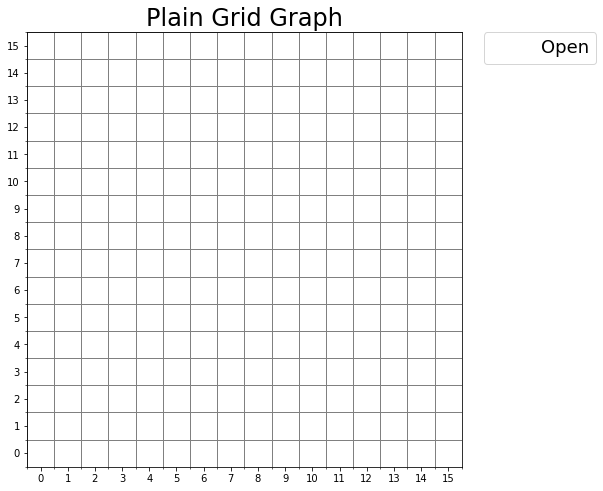

In [3]:
graph_size = 16
graph = create_grid_graph(graph_size)
show_grid_graph(graph, "Plain Grid Graph")

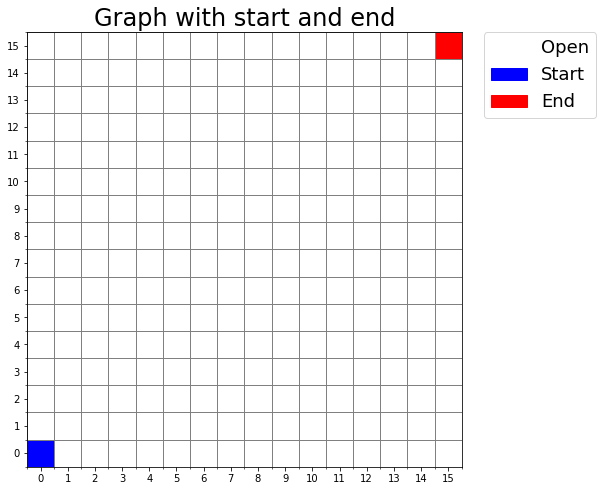

In [4]:
show_grid_graph(graph, "Graph with start and end", (0, 0), (15, 15))

In [5]:
def get_vertex_neighbors(graph: np.ndarray, vertex: Vertex) -> List[Vertex]:
    """Return all neighbors for the given vertex.

    Args:
        graph (np.ndarray): a grid graph
        vertex (Vertex): a vertex

    Returns:
        List[Vertex]: a list of adjacent vertices
    """

    height, width = graph.shape
    col, row = vertex

    def inbounds(v):
        c, r = v
        return 0 <= c < width and 0 <= r < height

    def not_wall(v):
        c, r = v
        return graph[r, c] != WALL

    possible_neighbors = [
        (col + 1, row),
        (col - 1, row),
        (col, row + 1),
        (col, row - 1),
    ]

    return [nei for nei in possible_neighbors if inbounds(nei) and not_wall(nei)]


def get_path_from_preds(
    preds: Dict[Vertex, Vertex], start: Vertex, end: Vertex
) -> List[Vertex]:
    """Find path from start to end using predecessory dictionary.

    Args:
        preds (Dict[Vertex, Vertex]): dictionary of predecessors
        start (Vertex): start vertex
        end (Vertex): end vertex

    Returns:
        List[Vertex]: path of vertices from start through end
    """

    current = end
    path = [current]

    while preds[current] != start:
        current = preds[current]
        path.append(current)

    path.append(start)
    path.reverse()
    return path


def get_path_bfs(
    graph: np.ndarray, start: Vertex, end: Vertex
) -> Tuple[List[Vertex], List[Vertex]]:
    """Compute path from start to end.

    Args:
        graph (np.ndarray): a grid graph
        start (Vertex): start vertex
        end (Vertex): end vertex

    Raises:
        ValueError: the graph does not have a path from start to end

    Returns:
        Tuple[List[Vertex], List[Vertex]]: path from start to end and a list of all
            visited vertices
    """

    vertices_to_visit = deque()
    vertices_to_visit.append(start)

    # Path is computed by back-tracing from end to start
    predecessors: Dict[Vertex, Vertex] = {start: start}

    while len(vertices_to_visit) > 0:

        vertex_tail = vertices_to_visit.popleft()

        for vertex_head in get_vertex_neighbors(graph, vertex_tail):

            if vertex_head not in predecessors:

                vertices_to_visit.append(vertex_head)
                predecessors[vertex_head] = vertex_tail

                if vertex_head == end:
                    path = get_path_from_preds(predecessors, start, end)

                    # Return the path and all vertices that were visited
                    return path, list(predecessors.keys())

    raise ValueError(f"Graph does not have a path from {start} to {end}")

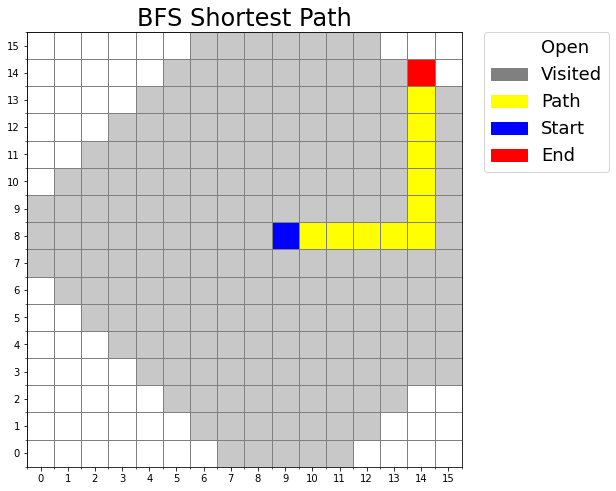

In [6]:
start = (9, 8)
end = (14, 14)

graph = create_grid_graph(graph_size)
path, visited = get_path_bfs(graph, start, end)

show_grid_graph(graph, "BFS Shortest Path", start, end, path, visited)

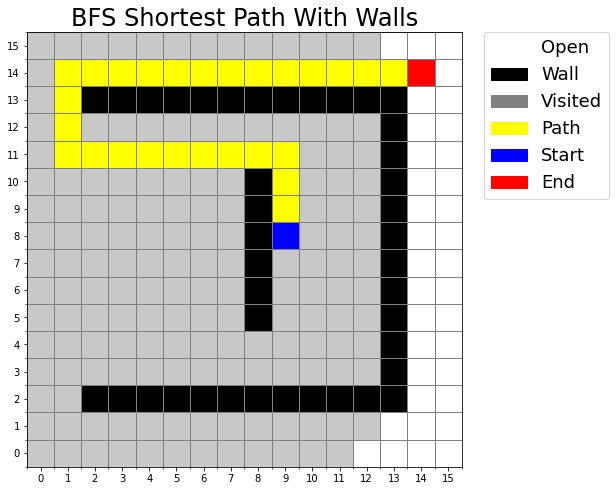

In [7]:
graph = create_grid_graph(graph_size, add_walls=True)
path, visited = get_path_bfs(graph, start, end)

show_grid_graph(graph, "BFS Shortest Path With Walls", start, end, path, visited)

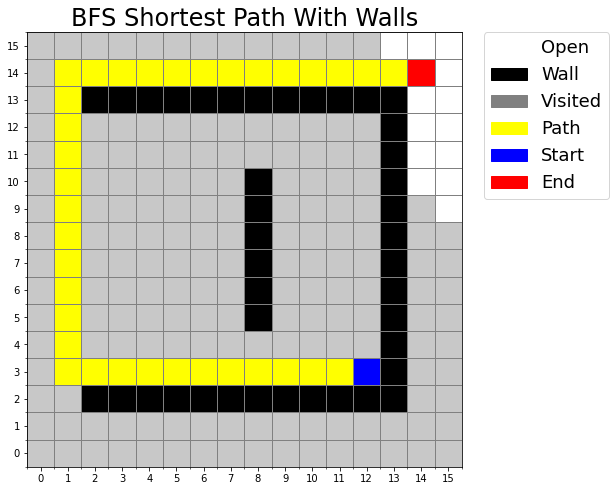

In [8]:
start = (12, 3)
end = (14, 14)

graph = create_grid_graph(graph_size, True)
path, visited = get_path_bfs(graph, start, end)

show_grid_graph(graph, "BFS Shortest Path With Walls", start, end, path, visited)

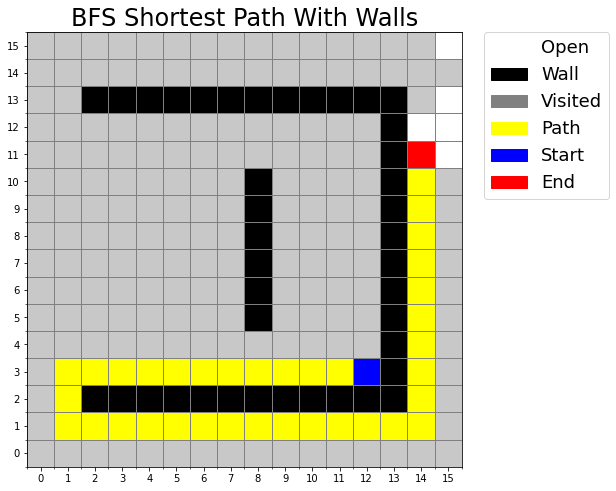

In [9]:
start = (12, 3)
end = (14, 11)

graph = create_grid_graph(graph_size, True)
path, visited = get_path_bfs(graph, start, end)

show_grid_graph(graph, "BFS Shortest Path With Walls", start, end, path, visited)

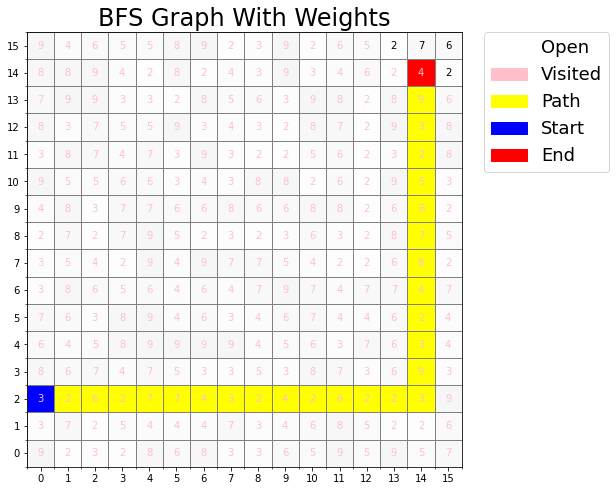

In [10]:
start = (0, 2)
end = (14, 14)

graph_with_weights = create_grid_graph(graph_size, with_costs=True)
path, visited = get_path_bfs(graph_with_weights, start, end)

show_grid_graph(
    graph_with_weights, "BFS Graph With Weights", start, end, path, visited, True
)

In [11]:
def get_path_slow_dijkstras(
    graph: np.ndarray, start: Vertex, end: Vertex
) -> Tuple[List[Vertex], List[Vertex]]:
    """An (inefficient) implementation of Dijkstra's.

    Args:
        graph (np.ndarray): a grid graph
        start (Vertex): start vertex
        end (Vertex): end vertex

    Raises:
        ValueError: the graph does not have a path from start to end

    Returns:
        Tuple[List[Vertex], List[Vertex]]: path from start to end and a list of all
            visited vertices
    """

    n = graph.size

    visited = {start}
    predecessors = {start: start}
    path_lengths = {start: 0}

    while len(visited) != n:

        length_of_min_path = inf
        vertex_head_of_min_path = None
        vertex_tail_of_min_path = None

        for vertex_tail in visited:

            for vertex_head in get_vertex_neighbors(graph, vertex_tail):

                if vertex_head not in visited:

                    col, row = vertex_head
                    to_weight = graph[row, col]

                    to_path_length = path_lengths[vertex_tail] + to_weight

                    if to_path_length < length_of_min_path:

                        length_of_min_path = to_path_length
                        vertex_head_of_min_path = vertex_head
                        vertex_tail_of_min_path = vertex_tail

        path_lengths[vertex_head_of_min_path] = length_of_min_path
        predecessors[vertex_head_of_min_path] = vertex_tail_of_min_path
        visited.add(vertex_head_of_min_path)

        if vertex_head_of_min_path == end:
            path = get_path_from_preds(predecessors, start, end)
            return path, list(predecessors.keys())
    
    raise ValueError(f"Graph does not have a path from {start} to {end}")

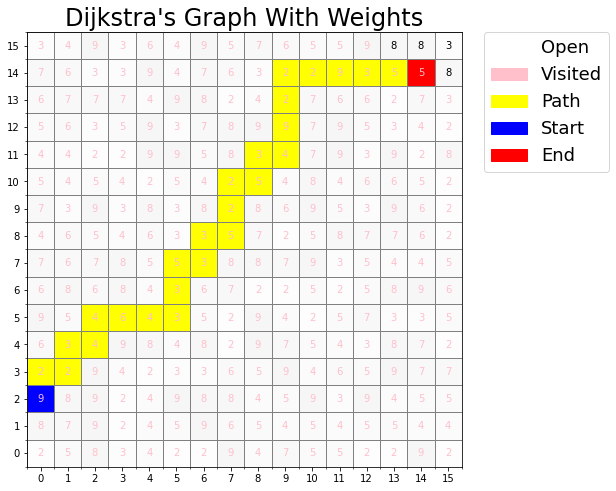

In [12]:
start = (0, 2)
end = (14, 14)

graph_with_weights = create_grid_graph(graph_size, with_costs=True)
path, visited = get_path_slow_dijkstras(graph_with_weights, start, end)

show_grid_graph(
    graph_with_weights, "Dijkstra's Graph With Weights", start, end, path, visited, True
)

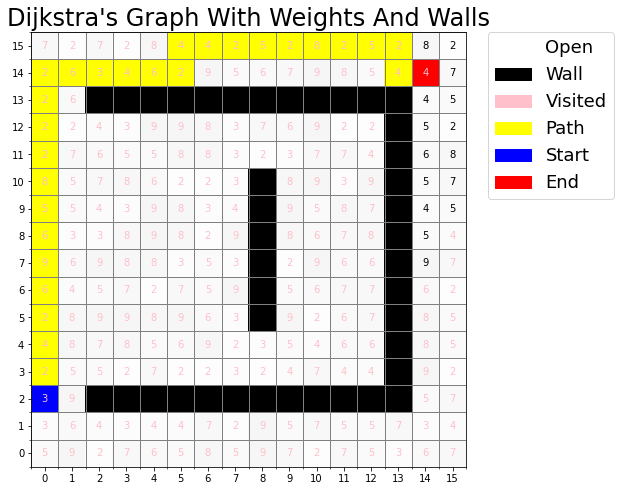

In [13]:
start = (0, 2)
end = (14, 14)

graph_with_weights = create_grid_graph(graph_size, add_walls=True, with_costs=True)
path, visited = get_path_slow_dijkstras(graph_with_weights, start, end)

show_grid_graph(
    graph_with_weights,
    "Dijkstra's Graph With Weights And Walls",
    start,
    end,
    path,
    visited,
    True,
)

In [14]:
def heuristic_cost(v1: Vertex, v2: Vertex):
    """An arbitrary A* cost heuristic."""
    return 3.5 * (fabs(v1[0] - v2[0]) + fabs(v1[1] - v2[1]))


def get_path_slow_astar(
    graph: np.ndarray, start: Vertex, end: Vertex
) -> Tuple[List[Vertex], List[Vertex]]:
    """An (inefficient) implementation of A*.

    Args:
        graph (np.ndarray): a grid graph
        start (Vertex): start vertex
        end (Vertex): end vertex

    Raises:
        ValueError: the graph does not have a path from start to end

    Returns:
        Tuple[List[Vertex], List[Vertex]]: path from start to end and a list of all
            visited vertices
    """

    vertices_to_visit = {start}
    predecessors = {start: start}

    # Path lengths from start to each vertex
    height, width = graph.shape
    path_lengths_from_start = {
        (col, row): inf for col in range(width) for row in range(height)
    }
    path_lengths_from_start[start] = 0

    # Possible path lengths from start to end through given vertex
    guessed_path_lengths_to_end = {start: heuristic_cost(start, end)}

    visited = set()

    while len(vertices_to_visit) > 0:

        length_of_min_guessed_path = inf

        for vertex_tail in vertices_to_visit:

            length_of_guessed_path = guessed_path_lengths_to_end[vertex_tail]

            if length_of_guessed_path < length_of_min_guessed_path:

                length_of_min_guessed_path = length_of_guessed_path
                vertex_tail_of_min_guessed_path = vertex_tail

        vertices_to_visit.remove(vertex_tail_of_min_guessed_path)
        visited.add(vertex_tail_of_min_guessed_path)

        vertex_tail_path_length = path_lengths_from_start[
            vertex_tail_of_min_guessed_path
        ]

        for vertex_head in get_vertex_neighbors(graph, vertex_tail_of_min_guessed_path):

            col, row = vertex_head
            updated_length = vertex_tail_path_length + graph[row, col]

            if updated_length < path_lengths_from_start[vertex_head]:

                predecessors[vertex_head] = vertex_tail_of_min_guessed_path
                path_lengths_from_start[vertex_head] = updated_length
                guessed_path_lengths_to_end[
                    vertex_head
                ] = updated_length + heuristic_cost(vertex_head, end)

                if vertex_head == end:
                    path = get_path_from_preds(predecessors, start, end)
                    return path, list(visited)

                if vertex_head not in vertices_to_visit:
                    vertices_to_visit.add(vertex_head)

    raise ValueError(f"Graph does not have a path from {start} to {end}")

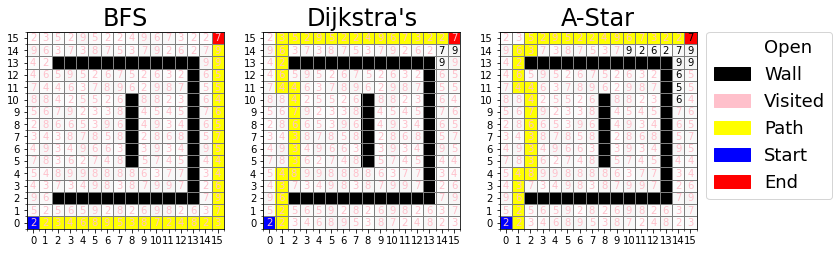

In [16]:
start = (0, 0)
end = (15, 15)

walls = True
costs = True

graph_weighted = create_grid_graph(graph_size, add_walls=walls, with_costs=costs)

path_bfs, visit_bfs = get_path_bfs(graph_weighted, start, end)
path_dij, visit_dij = get_path_slow_dijkstras(graph_weighted, start, end)
path_ast, visit_ast = get_path_slow_astar(graph_weighted, start, end)

_, axes = plt.subplots(1, 3, figsize=(12, 5))

show_grid_graph(
    graph_weighted, "BFS", start, end, path_bfs, visit_bfs, costs, ax=axes[0], show_legend=False
)
show_grid_graph(
    graph_weighted, "Dijkstra's", start, end, path_dij, visit_dij, costs, ax=axes[1], show_legend=False
)
show_grid_graph(
    graph_weighted, "A-Star", start, end, path_ast, visit_ast, costs, ax=axes[2]
)